# Setup Awal

In [1]:
import os
import numpy as np
import json
import pickle
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.optim as optim
from torch.optim import AdamW   
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split  
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import KFold  

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Dataset

In [3]:
dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

kelas = sorted(os.listdir(dataset_path))

jumlah_per_kelas = {}

for k in kelas:
    folder_path = os.path.join(dataset_path, k)
    file_list = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    jumlah_per_kelas[k] = len(file_list)

print("Jumlah gambar per kelas:")
for k, jml in jumlah_per_kelas.items():
    print(f"{k}: {jml}")


Jumlah gambar per kelas:
other_activities: 1184
safe_driving: 1679
talking_phone: 1513
texting_phone: 1561
turning: 1339


# Transformasi gambar

Kelas acak: safe_driving
Gambar acak: img_44061.jpg
Path gambar: /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset/safe_driving/img_44061.jpg


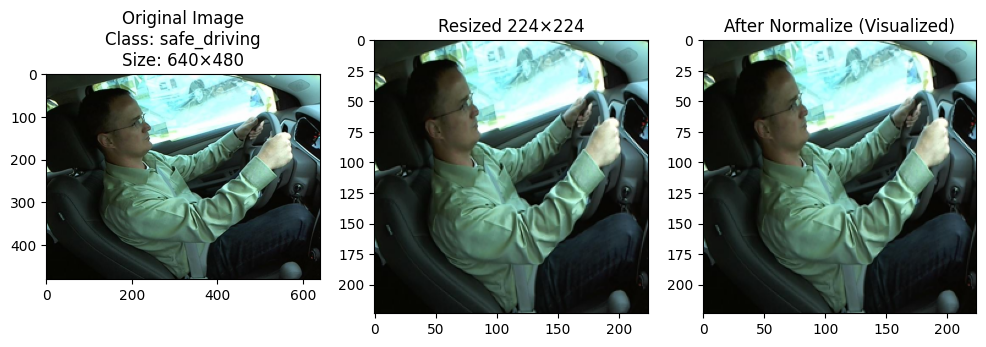

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================
# 1. SET PATH DATASET
# ============================

dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

# ambil semua folder kelas
kelas = sorted(os.listdir(dataset_path))

# pilih kelas random
kelas_random = random.choice(kelas)

# pilih gambar random dari kelas itu
gambar_list = os.listdir(os.path.join(dataset_path, kelas_random))
gambar_random = random.choice(gambar_list)

sample_image_path = os.path.join(dataset_path, kelas_random, gambar_random)

print("Kelas acak:", kelas_random)
print("Gambar acak:", gambar_random)
print("Path gambar:", sample_image_path)

# ============================
# 2. LOAD GAMBAR
# ============================

img_original = Image.open(sample_image_path).convert("RGB")
orig_w, orig_h = img_original.size

# resize
img_resized = img_original.resize((224, 224))

# convert ke numpy (0–1)
img_np = np.array(img_resized).astype("float32") / 255.0

# normalize imagenet
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_norm = (img_np - mean) / std

# unnormalize untuk visualisasi
img_unnorm = (img_norm * std) + mean
img_unnorm = np.clip(img_unnorm, 0, 1)

# ============================
# 3. PLOT GAMBAR
# ============================

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_original)
plt.title(f"Original Image\nClass: {kelas_random}\nSize: {orig_w}×{orig_h}")
plt.axis("on")

plt.subplot(1,3,2)
plt.imshow(img_resized)
plt.title("Resized 224×224")
plt.axis("on")

plt.subplot(1,3,3)
plt.imshow(img_unnorm)
plt.title("After Normalize (Visualized)")
plt.axis("on")

plt.show()


# Setup k-fold=5

In [5]:
json_path = '/kaggle/input/kfoldsta/Kfolds_TA.json'

with open(json_path, "r") as f:
    raw = json.load(f)

# Ekstrak meta dan override dataset_path/class_names bila ada
meta = raw.get("meta", {})
if isinstance(meta, dict):
    ds_root = meta.get("dataset_root")
    if ds_root:
        dataset_path = ds_root  # override global dataset path
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    if "n_splits" in meta:
        n_splits = int(meta["n_splits"])
    if "seed" in meta:
        seed = int(meta["seed"])

# Normalisasi folds: ambil semua key selain 'meta'
kfold_splits = {k: v for k, v in raw.items() if k != "meta"}

print("\nPembagian Data K-Fold (dari JSON)")
print(f"Dataset root   : {dataset_path}")
if "class_counts" in meta:
    total_imgs_meta = sum(meta["class_counts"].values())
    print(f"Total gambar   : {total_imgs_meta:,} (dari meta)")
    print("Kelas          : " + ", ".join(class_names))

first_fold_key = next(iter(sorted(kfold_splits.keys())))
first_fold = kfold_splits[first_fold_key]
train_count = len(first_fold.get("train", []))
val_count   = len(first_fold.get("val", []))
total_count = train_count + val_count 

print(f"Jumlah Fold    : {len(kfold_splits)}")
print(f"Train          : {train_count:,} gambar")
print(f"Val            : {val_count:,} gambar")
print(f"Total          : {total_count:,} gambar")


Pembagian Data K-Fold (dari JSON)
Dataset root   : /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset
Jumlah Fold    : 5
Train          : 5,820 gambar
Val            : 1,456 gambar
Total          : 7,276 gambar


# Dataset loader untuk memuat gambar dan label

In [7]:
class DriverBehaviorDataset(Dataset):
    def __init__(self, root_dir, file_list, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        rel_path = self.file_list[idx]
        # Normalisasi path JSON (posix) ke path OS lokal (Windows)
        local_rel = rel_path.replace("/", os.sep)
        img_path = os.path.normpath(os.path.join(self.root_dir, local_rel))

        image = Image.open(img_path).convert('RGB')

        # Ambil label dari segmen folder pertama di path JSON
        class_name = rel_path.split("/", 1)[0]
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Loader dataset berbasis JSON

In [8]:
def load_dataloaders_from_split_json(json_path, dataset_path, fold_name,
                                     batch_size=32, img_size=(224, 224)):
    
    with open(json_path, "r") as f:
        raw = json.load(f)

    meta = raw.get("meta", {})
    ds_root = meta.get("dataset_root") or dataset_path

    # Ambil nama kelas
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    else:
        class_names = sorted(
            [d for d in os.listdir(ds_root)
             if os.path.isdir(os.path.join(ds_root, d))]
        )

    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    # Transform image
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cek fold
    folds_data = {k: v for k, v in raw.items() if k != "meta"}
    if fold_name not in folds_data:
        raise KeyError(f"Fold '{fold_name}' tidak ditemukan di JSON.")

    fold = folds_data[fold_name]
    train_files = fold.get("train", [])
    val_files   = fold.get("val", [])

    # Dataset
    train_dataset = DriverBehaviorDataset(ds_root, train_files, class_to_idx, transform)
    val_dataset   = DriverBehaviorDataset(ds_root, val_files,   class_to_idx, transform)

    # DataLoader
    num_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)

    return train_loader, val_loader, class_to_idx, class_names, ds_root


# Model

In [9]:
num_classes = len(os.listdir(dataset_path))

def mobnetv2_model(num_classes):
    model = models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model

# Training dan evaluasi model mobilenet 

Training Fold 1


Epoch 1/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.44it/s]


Epoch [1/15] Train Loss: 1.5829 Acc: 0.2660 | Val Loss: 1.5091 Acc: 0.3468


Epoch 2/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]


Epoch [2/15] Train Loss: 1.3778 Acc: 0.4277 | Val Loss: 1.3123 Acc: 0.4554


Epoch 3/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]


Epoch [3/15] Train Loss: 1.0547 Acc: 0.5794 | Val Loss: 1.1376 Acc: 0.5385


Epoch 4/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]


Epoch [4/15] Train Loss: 0.8345 Acc: 0.6742 | Val Loss: 1.0228 Acc: 0.5948


Epoch 5/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.57it/s]


Epoch [5/15] Train Loss: 0.6473 Acc: 0.7622 | Val Loss: 0.8562 Acc: 0.6655


Epoch 6/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]


Epoch [6/15] Train Loss: 0.4554 Acc: 0.8356 | Val Loss: 0.8811 Acc: 0.6717


Epoch 7/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]


Epoch [7/15] Train Loss: 0.3296 Acc: 0.8849 | Val Loss: 0.9151 Acc: 0.6745


Epoch 8/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]


Epoch [8/15] Train Loss: 0.2357 Acc: 0.9192 | Val Loss: 0.8225 Acc: 0.7143


Epoch 9/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


Epoch [9/15] Train Loss: 0.2150 Acc: 0.9249 | Val Loss: 0.8903 Acc: 0.7109


Epoch 10/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


Epoch [10/15] Train Loss: 0.1628 Acc: 0.9478 | Val Loss: 0.8039 Acc: 0.7404


Epoch 11/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


Epoch [11/15] Train Loss: 0.1268 Acc: 0.9574 | Val Loss: 0.8693 Acc: 0.7321


Epoch 12/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]


Epoch [12/15] Train Loss: 0.1159 Acc: 0.9608 | Val Loss: 0.8260 Acc: 0.7534


Epoch 13/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]


Epoch [13/15] Train Loss: 0.1185 Acc: 0.9620 | Val Loss: 0.9793 Acc: 0.7246


Epoch 14/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]


Epoch [14/15] Train Loss: 0.1132 Acc: 0.9634 | Val Loss: 0.7561 Acc: 0.7644


Epoch 15/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


Epoch [15/15] Train Loss: 0.1024 Acc: 0.9655 | Val Loss: 0.9046 Acc: 0.7424
Evaluasi Model:
Accuracy: 0.7644
Precision: 0.7667 | Recall: 0.7638 | F1-Score: 0.7614
Classification Report:
                  precision    recall  f1-score   support

other_activities     0.6454    0.6532    0.6493       248
    safe_driving     0.8281    0.8230    0.8255       322
   talking_phone     0.7009    0.7785    0.7376       316
   texting_phone     0.8880    0.6815    0.7712       314
         turning     0.7713    0.8828    0.8233       256

        accuracy                         0.7644      1456
       macro avg     0.7667    0.7638    0.7614      1456
    weighted avg     0.7723    0.7644    0.7643      1456



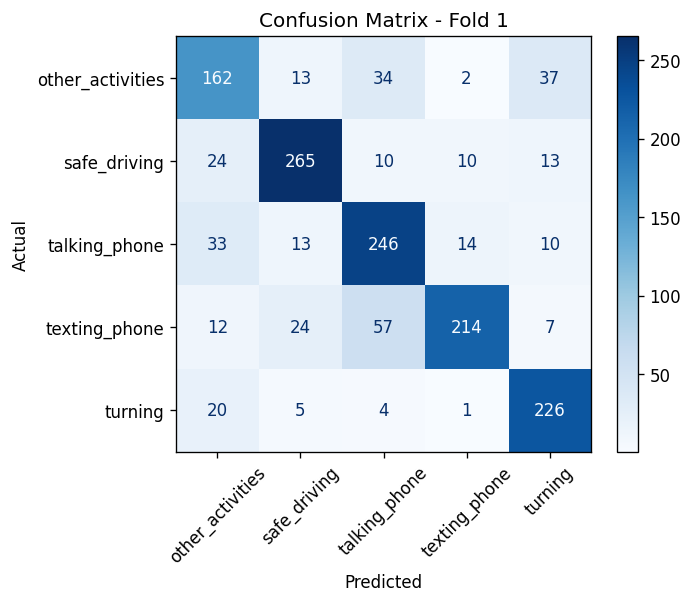

Training Fold 2


Epoch 1/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Epoch [1/15] Train Loss: 1.5694 Acc: 0.2731 | Val Loss: 1.4670 Acc: 0.3904


Epoch 2/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]


Epoch [2/15] Train Loss: 1.3009 Acc: 0.4695 | Val Loss: 1.2528 Acc: 0.4770


Epoch 3/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]


Epoch [3/15] Train Loss: 0.9893 Acc: 0.6147 | Val Loss: 1.1172 Acc: 0.5533


Epoch 4/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]


Epoch [4/15] Train Loss: 0.7132 Acc: 0.7279 | Val Loss: 0.8929 Acc: 0.6536


Epoch 5/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch [5/15] Train Loss: 0.5324 Acc: 0.8048 | Val Loss: 0.8555 Acc: 0.6900


Epoch 6/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


Epoch [6/15] Train Loss: 0.3739 Acc: 0.8688 | Val Loss: 0.7571 Acc: 0.7285


Epoch 7/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


Epoch [7/15] Train Loss: 0.2412 Acc: 0.9179 | Val Loss: 0.8293 Acc: 0.7340


Epoch 8/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


Epoch [8/15] Train Loss: 0.2022 Acc: 0.9340 | Val Loss: 0.7587 Acc: 0.7299


Epoch 9/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]


Epoch [9/15] Train Loss: 0.1720 Acc: 0.9438 | Val Loss: 0.7044 Acc: 0.7856


Epoch 10/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


Epoch [10/15] Train Loss: 0.1573 Acc: 0.9449 | Val Loss: 0.6438 Acc: 0.7780


Epoch 11/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


Epoch [11/15] Train Loss: 0.1141 Acc: 0.9636 | Val Loss: 0.6993 Acc: 0.7766


Epoch 12/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


Epoch [12/15] Train Loss: 0.1020 Acc: 0.9682 | Val Loss: 0.6497 Acc: 0.8007


Epoch 13/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


Epoch [13/15] Train Loss: 0.1033 Acc: 0.9679 | Val Loss: 0.7941 Acc: 0.7622


Epoch 14/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]


Epoch [14/15] Train Loss: 0.1113 Acc: 0.9625 | Val Loss: 0.7506 Acc: 0.7766


Epoch 15/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


Epoch [15/15] Train Loss: 0.0871 Acc: 0.9699 | Val Loss: 0.7033 Acc: 0.7897
Evaluasi Model:
Accuracy: 0.8007
Precision: 0.7955 | Recall: 0.7932 | F1-Score: 0.7930
Classification Report:
                  precision    recall  f1-score   support

other_activities     0.6620    0.5958    0.6272       240
    safe_driving     0.8935    0.8394    0.8656       330
   talking_phone     0.7907    0.7702    0.7803       309
   texting_phone     0.7637    0.8797    0.8176       316
         turning     0.8674    0.8808    0.8740       260

        accuracy                         0.8007      1455
       macro avg     0.7955    0.7932    0.7930      1455
    weighted avg     0.8007    0.8007    0.7993      1455



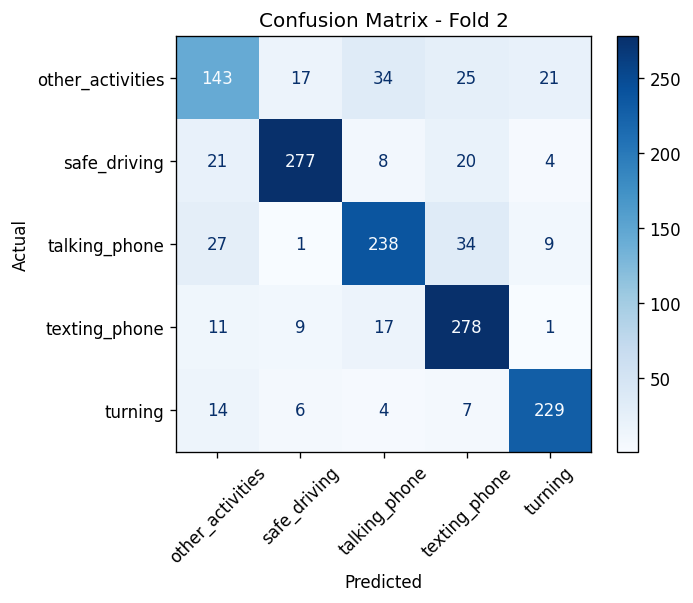

Training Fold 3


Epoch 1/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.71it/s]


Epoch [1/15] Train Loss: 1.5880 Acc: 0.2517 | Val Loss: 1.5261 Acc: 0.3141


Epoch 2/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]


Epoch [2/15] Train Loss: 1.3933 Acc: 0.4142 | Val Loss: 1.2999 Acc: 0.4646


Epoch 3/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]


Epoch [3/15] Train Loss: 1.0973 Acc: 0.5602 | Val Loss: 1.0766 Acc: 0.5711


Epoch 4/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]


Epoch [4/15] Train Loss: 0.8372 Acc: 0.6784 | Val Loss: 0.9113 Acc: 0.6481


Epoch 5/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]


Epoch [5/15] Train Loss: 0.6192 Acc: 0.7755 | Val Loss: 0.9627 Acc: 0.6378


Epoch 6/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]


Epoch [6/15] Train Loss: 0.4667 Acc: 0.8337 | Val Loss: 1.0953 Acc: 0.6419


Epoch 7/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.89it/s]


Epoch [7/15] Train Loss: 0.3316 Acc: 0.8885 | Val Loss: 0.7629 Acc: 0.7326


Epoch 8/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]


Epoch [8/15] Train Loss: 0.2568 Acc: 0.9144 | Val Loss: 0.7822 Acc: 0.7368


Epoch 9/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.71it/s]


Epoch [9/15] Train Loss: 0.1865 Acc: 0.9411 | Val Loss: 0.7885 Acc: 0.7299


Epoch 10/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]


Epoch [10/15] Train Loss: 0.1672 Acc: 0.9421 | Val Loss: 0.7272 Acc: 0.7643


Epoch 11/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]


Epoch [11/15] Train Loss: 0.1421 Acc: 0.9514 | Val Loss: 0.7372 Acc: 0.7718


Epoch 12/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Epoch [12/15] Train Loss: 0.1234 Acc: 0.9591 | Val Loss: 0.7149 Acc: 0.7911


Epoch 13/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]


Epoch [13/15] Train Loss: 0.1012 Acc: 0.9658 | Val Loss: 0.7591 Acc: 0.7773


Epoch 14/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]


Epoch [14/15] Train Loss: 0.0874 Acc: 0.9711 | Val Loss: 0.6830 Acc: 0.7897


Epoch 15/15 - Val: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]


Epoch [15/15] Train Loss: 0.0698 Acc: 0.9758 | Val Loss: 0.6614 Acc: 0.8103
Evaluasi Model:
Accuracy: 0.8103
Precision: 0.8138 | Recall: 0.8027 | F1-Score: 0.8042
Classification Report:
                  precision    recall  f1-score   support

other_activities     0.6492    0.6970    0.6722       231
    safe_driving     0.7698    0.9386    0.8458       342
   talking_phone     0.8141    0.7526    0.7821       291
   texting_phone     0.9373    0.7563    0.8371       316
         turning     0.8985    0.8691    0.8835       275

        accuracy                         0.8103      1455
       macro avg     0.8138    0.8027    0.8042      1455
    weighted avg     0.8202    0.8103    0.8108      1455



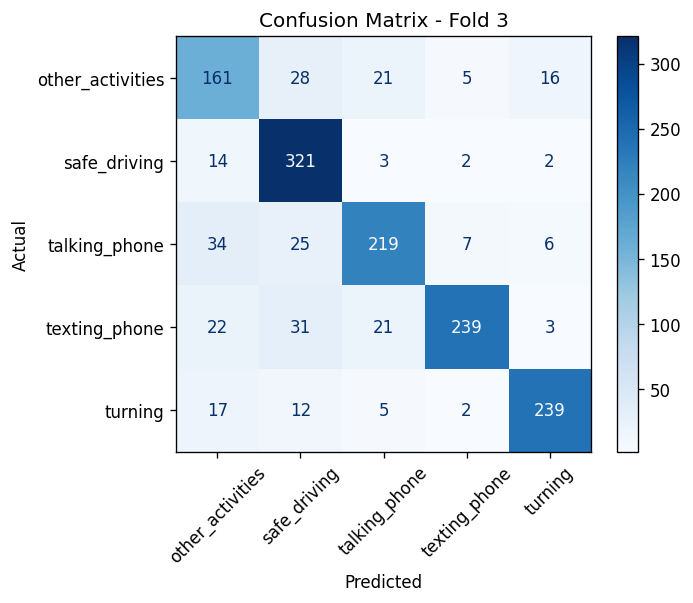

Training Fold 4


Epoch 1/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]


Epoch [1/15] Train Loss: 1.5823 Acc: 0.2623 | Val Loss: 1.5311 Acc: 0.3113


Epoch 2/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Epoch [2/15] Train Loss: 1.3698 Acc: 0.4305 | Val Loss: 1.3385 Acc: 0.4694


Epoch 3/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Epoch [3/15] Train Loss: 0.9984 Acc: 0.6088 | Val Loss: 1.0655 Acc: 0.5856


Epoch 4/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]


Epoch [4/15] Train Loss: 0.7420 Acc: 0.7250 | Val Loss: 0.8854 Acc: 0.6667


Epoch 5/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


Epoch [5/15] Train Loss: 0.5328 Acc: 0.8093 | Val Loss: 0.8411 Acc: 0.6887


Epoch 6/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


Epoch [6/15] Train Loss: 0.3875 Acc: 0.8612 | Val Loss: 0.8014 Acc: 0.7175


Epoch 7/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


Epoch [7/15] Train Loss: 0.2806 Acc: 0.9024 | Val Loss: 0.9507 Acc: 0.7045


Epoch 8/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]


Epoch [8/15] Train Loss: 0.2313 Acc: 0.9191 | Val Loss: 1.0709 Acc: 0.6660


Epoch 9/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Epoch [9/15] Train Loss: 0.1769 Acc: 0.9445 | Val Loss: 0.7997 Acc: 0.7402


Epoch 10/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


Epoch [10/15] Train Loss: 0.1463 Acc: 0.9524 | Val Loss: 0.7712 Acc: 0.7636


Epoch 11/15 - Val: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


Epoch [11/15] Train Loss: 0.1387 Acc: 0.9534 | Val Loss: 0.8164 Acc: 0.7540


Epoch 12/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


Epoch [12/15] Train Loss: 0.1199 Acc: 0.9588 | Val Loss: 0.7263 Acc: 0.7711


Epoch 13/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


Epoch [13/15] Train Loss: 0.1106 Acc: 0.9627 | Val Loss: 0.9607 Acc: 0.7402


Epoch 14/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch [14/15] Train Loss: 0.1043 Acc: 0.9672 | Val Loss: 0.9132 Acc: 0.7402


Epoch 15/15 - Val: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


Epoch [15/15] Train Loss: 0.1019 Acc: 0.9655 | Val Loss: 0.7332 Acc: 0.7794
Evaluasi Model:
Accuracy: 0.7794
Precision: 0.7870 | Recall: 0.7808 | F1-Score: 0.7800
Classification Report:
                  precision    recall  f1-score   support

other_activities     0.5613    0.7409    0.6387       247
    safe_driving     0.8612    0.7446    0.7987       325
   talking_phone     0.8195    0.7229    0.7682       314
   texting_phone     0.7879    0.8069    0.7973       290
         turning     0.9051    0.8889    0.8969       279

        accuracy                         0.7794      1455
       macro avg     0.7870    0.7808    0.7800      1455
    weighted avg     0.7951    0.7794    0.7835      1455



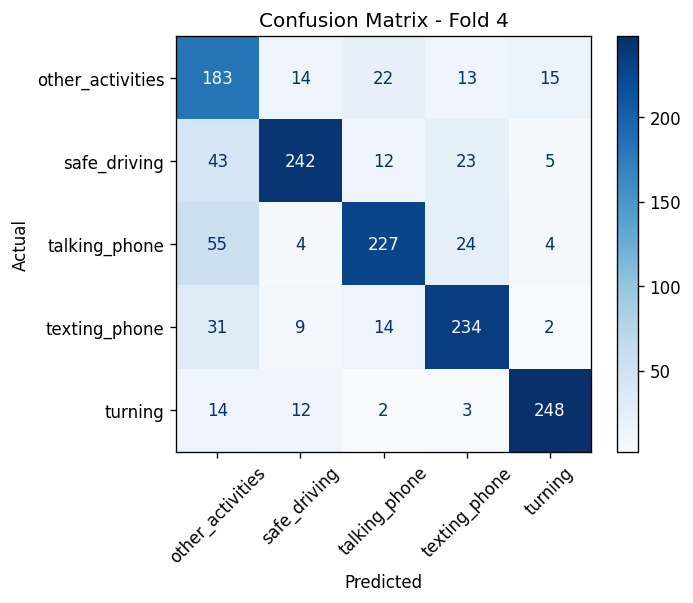

Training Fold 5


Epoch 1/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


Epoch [1/15] Train Loss: 1.5832 Acc: 0.2561 | Val Loss: 1.4759 Acc: 0.3498


Epoch 2/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.08it/s]


Epoch [2/15] Train Loss: 1.3495 Acc: 0.4257 | Val Loss: 1.2712 Acc: 0.4529


Epoch 3/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s]


Epoch [3/15] Train Loss: 1.0688 Acc: 0.5563 | Val Loss: 1.0996 Acc: 0.5485


Epoch 4/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.10it/s]


Epoch [4/15] Train Loss: 0.8634 Acc: 0.6684 | Val Loss: 0.9341 Acc: 0.6199


Epoch 5/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.11it/s]


Epoch [5/15] Train Loss: 0.6474 Acc: 0.7545 | Val Loss: 0.7569 Acc: 0.7148


Epoch 6/15 - Val: 100%|██████████| 46/46 [00:08<00:00,  5.11it/s]


Epoch [6/15] Train Loss: 0.4736 Acc: 0.8289 | Val Loss: 0.9134 Acc: 0.6598


Epoch 7/15 - Val: 100%|██████████| 46/46 [00:08<00:00,  5.14it/s]


Epoch [7/15] Train Loss: 0.3416 Acc: 0.8794 | Val Loss: 0.7932 Acc: 0.7168


Epoch 8/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s]


Epoch [8/15] Train Loss: 0.2676 Acc: 0.9076 | Val Loss: 0.6887 Acc: 0.7588


Epoch 9/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.09it/s]


Epoch [9/15] Train Loss: 0.2201 Acc: 0.9266 | Val Loss: 0.7568 Acc: 0.7512


Epoch 10/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s]


Epoch [10/15] Train Loss: 0.1641 Acc: 0.9457 | Val Loss: 0.6530 Acc: 0.7842


Epoch 11/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.05it/s]


Epoch [11/15] Train Loss: 0.1298 Acc: 0.9558 | Val Loss: 0.6202 Acc: 0.8055


Epoch 12/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.04it/s]


Epoch [12/15] Train Loss: 0.1481 Acc: 0.9469 | Val Loss: 0.9019 Acc: 0.7265


Epoch 13/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]


Epoch [13/15] Train Loss: 0.1261 Acc: 0.9581 | Val Loss: 0.5636 Acc: 0.8220


Epoch 14/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s]


Epoch [14/15] Train Loss: 0.0923 Acc: 0.9705 | Val Loss: 0.5542 Acc: 0.8268


Epoch 15/15 - Val: 100%|██████████| 46/46 [00:09<00:00,  5.10it/s]


Epoch [15/15] Train Loss: 0.0778 Acc: 0.9751 | Val Loss: 0.5675 Acc: 0.8247
Evaluasi Model:
Accuracy: 0.8268
Precision: 0.8160 | Recall: 0.8163 | F1-Score: 0.8158
Classification Report:
                  precision    recall  f1-score   support

other_activities     0.6765    0.6330    0.6540       218
    safe_driving     0.8870    0.8500    0.8681       360
   talking_phone     0.8103    0.8304    0.8202       283
   texting_phone     0.8289    0.8646    0.8464       325
         turning     0.8773    0.9033    0.8901       269

        accuracy                         0.8268      1455
       macro avg     0.8160    0.8163    0.8158      1455
    weighted avg     0.8258    0.8268    0.8259      1455



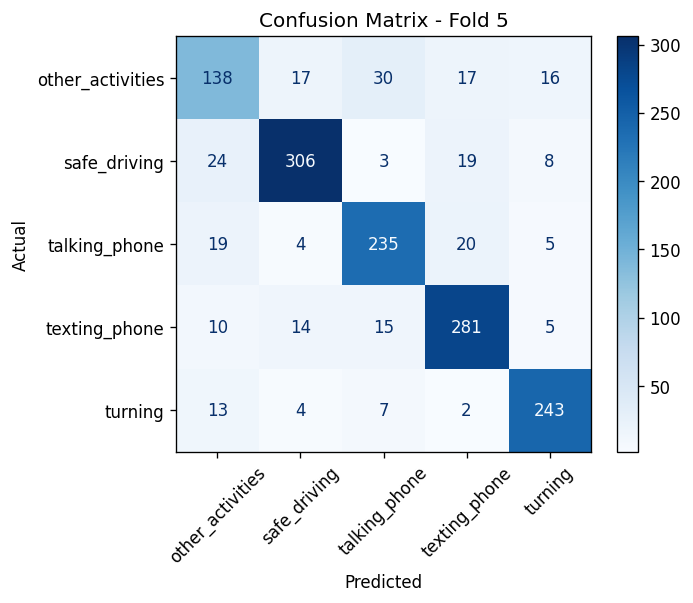

In [11]:
# Hyperparameter
num_epochs = 15
learning_rate = 0.0001

# Dictionary untuk menyimpan hasil semua fold
all_fold_results = {}

# Fungsi training per fold dengan tracking yang lebih detail
def train_fold(fold_name, train_loader, val_loader, num_classes):
    print(f"Training {fold_name.replace('_', ' ').title()}")

    model = mobnetv2_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_epoch = 0
    best_model_path = f'{fold_name}_best_model.pth'

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Track best validation accuracy dan simpan model terbaik
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Evaluasi pada validation set menggunakan model terbaik
    best_model = mobnetv2_model(num_classes).to(device)
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            preds = outputs.argmax(1).detach().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    # Gunakan nama kelas jika tersedia
    if 'class_names' in globals() and len(class_names) == num_classes:
        target_names = [str(c) for c in class_names]
    else:
        target_names = [str(i) for i in range(num_classes)]
    cls_report = classification_report(
        all_labels, all_preds,
        labels=list(range(num_classes)),
        target_names=target_names,
        digits=4, zero_division=0
    )
    print("Evaluasi Model:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(cls_report)

    # Plot confusion matrix
    labels_display = class_names if 'class_names' in globals() else list(range(num_classes))
    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
    disp.plot(include_values=True, cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f'Confusion Matrix - {fold_name.replace("_", " ").title()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.tick_params(axis='x', labelrotation=45)
    plt.tight_layout()
    plt.show()

    # Simpan hasil fold
    fold_results = {
        'fold_name': fold_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'eval': {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'confusion_matrix': cm,
            'classification_report': cls_report,
        },
        'best_model_path': best_model_path
    }
    
    # Simpan ke dictionary global
    all_fold_results[fold_name] = fold_results
    
    # Simpan hasil fold ke file
    with open(f'{fold_name}_results.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

def train_all_folds(fold_loaders, num_classes):
    results = {}
    for fold_name, loaders in fold_loaders.items():
        if isinstance(loaders, dict):
            train_loader = loaders.get('train') or loaders.get('train_loader')
            val_loader = loaders.get('val') or loaders.get('val_loader')
        else:
            train_loader, val_loader = loaders
        results[fold_name] = train_fold(fold_name, train_loader, val_loader, num_classes)
    with open('all_folds_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    return results

fold_names = sorted(kfold_splits.keys(), key=lambda n: int(n.split("_")[-1]) if n.split("_")[-1].isdigit() else n)

fold_loaders = {}
class_names = None  
for fold_name in fold_names:
    tr_loader, va_loader, class_to_idx, class_names_local, ds_root = load_dataloaders_from_split_json(
        json_path=json_path,
        dataset_path=dataset_path,
        fold_name=fold_name,
        batch_size=32,
        img_size=(224, 224),
    )
    fold_loaders[fold_name] = {'train': tr_loader, 'val': va_loader}
    if class_names is None:
        class_names = class_names_local
        dataset_path = ds_root  
num_classes = len(class_names)
all_fold_results = train_all_folds(fold_loaders, num_classes)

# Evaluasi rata-rata kfold

In [12]:
print("\n==================== HASIL K-FOLD CROSS VALIDATION ====================\n")

acc_list = []
prec_list = []
rec_list = []
f1_list = []

for fold_name, result in sorted(all_fold_results.items(), key=lambda x: int(x[0].split("_")[-1])):
    acc  = result['eval']['accuracy']
    prec = result['eval']['precision']
    rec  = result['eval']['recall']
    f1   = result['eval']['f1']

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)

    print(f"{fold_name}:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print("-" * 60)

# Hitung rata-rata seluruh fold
mean_acc  = np.mean(acc_list)
mean_prec = np.mean(prec_list)
mean_rec  = np.mean(rec_list)
mean_f1   = np.mean(f1_list)

print("\n====================== RATA-RATA 5 FOLD ======================\n")
print(f"Avg Accuracy  : {mean_acc:.4f}")
print(f"Avg Precision : {mean_prec:.4f}")
print(f"Avg Recall    : {mean_rec:.4f}")
print(f"Avg F1-Score  : {mean_f1:.4f}")


==================== HASIL K-FOLD CROSS VALIDATION ====================

fold_1:
  Accuracy  : 0.7644
  Precision : 0.7667
  Recall    : 0.7638
  F1-Score  : 0.7614
------------------------------------------------------------
fold_2:
  Accuracy  : 0.8007
  Precision : 0.7955
  Recall    : 0.7932
  F1-Score  : 0.7930
------------------------------------------------------------
fold_3:
  Accuracy  : 0.8103
  Precision : 0.8138
  Recall    : 0.8027
  F1-Score  : 0.8042
------------------------------------------------------------
fold_4:
  Accuracy  : 0.7794
  Precision : 0.7870
  Recall    : 0.7808
  F1-Score  : 0.7800
------------------------------------------------------------
fold_5:
  Accuracy  : 0.8268
  Precision : 0.8160
  Recall    : 0.8163
  F1-Score  : 0.8158
------------------------------------------------------------

====================== RATA-RATA 5 FOLD ======================

Avg Accuracy  : 0.7963
Avg Precision : 0.7958
Avg Recall    : 0.7914
Avg F1-Score  : 0.7909


# Evaluasi menggunakan data test

In [19]:
# FUNGSI VALIDASI
def validate(model, dataloader, criterion, device="cuda"):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc

criterion = nn.CrossEntropyLoss()
val_results = {}

for fold_name in fold_loaders.keys():

    print(f"\n=== Evaluasi Validation Set: {fold_name} ===")

    # Load model terbaik per fold
    model_path = f"/kaggle/working/fold_5_best_model.pth"

    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model = model.to(device)

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Ambil val loader
    val_loader = fold_loaders[fold_name]["val"]

    # Hitung loss & akurasi
    val_loss, val_acc = validate(model, val_loader, criterion, device=device)

    val_results[fold_name] = {
        "loss": val_loss,
        "acc": val_acc
    }

    print(f"Validation Loss : {val_loss:.4f}")
    print(f"Validation Acc  : {val_acc * 100:.2f}%")

mean_acc  = np.mean([v["acc"]  for v in val_results.values()])
mean_loss = np.mean([v["loss"] for v in val_results.values()])

print("\n=== RATA-RATA VALIDATION SET ===")
print(f"Avg Loss : {mean_loss:.4f}")
print(f"Avg Acc  : {mean_acc * 100:.2f}%")



=== Evaluasi Validation Set: fold_1 ===
Validation Loss : 0.0280
Validation Acc  : 99.38%

=== Evaluasi Validation Set: fold_2 ===
Validation Loss : 0.0287
Validation Acc  : 99.38%

=== Evaluasi Validation Set: fold_3 ===
Validation Loss : 0.0321
Validation Acc  : 99.59%

=== Evaluasi Validation Set: fold_4 ===
Validation Loss : 0.0293
Validation Acc  : 99.31%

=== Evaluasi Validation Set: fold_5 ===
Validation Loss : 0.5542
Validation Acc  : 82.68%

=== RATA-RATA VALIDATION SET ===
Avg Loss : 0.1345
Avg Acc  : 96.07%


# Visualisasi akurasi tiap fold

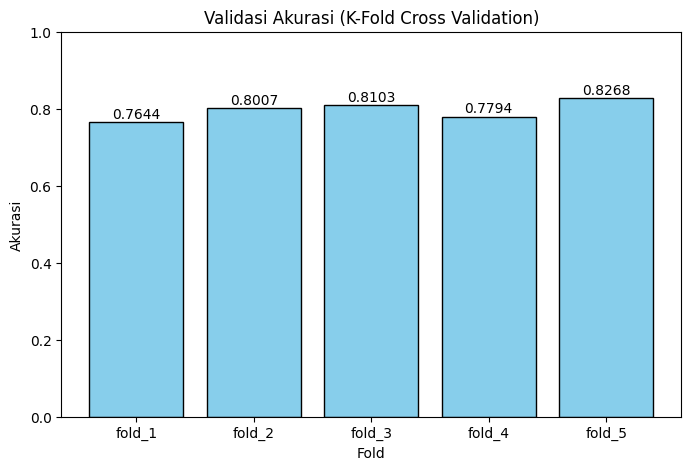

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# === 1️⃣ Muat hasil dari file .pkl ===
with open("/kaggle/working/all_folds_results.pkl", "rb") as f:
    all_fold_results = pickle.load(f)

# === 2️⃣ Ambil akurasi dan waktu per fold ===
fold_names = list(all_fold_results.keys())
accuracies = [v['eval']['accuracy'] for v in all_fold_results.values()]

# Pastikan data tidak kosong
if len(accuracies) == 0:
    print("⚠️ Tidak ada data akurasi di file all_fold_results.pkl. Pastikan training sudah selesai dengan benar.")
else:
    # === 3️⃣ Visualisasi dengan diagram batang ===
    plt.figure(figsize=(8,5))
    bars = plt.bar(fold_names, accuracies, color='skyblue', edgecolor='black')
    plt.title("Validasi Akurasi (K-Fold Cross Validation)")
    plt.xlabel("Fold")
    plt.ylabel("Akurasi")
    plt.ylim(0, 1)

    # Tambahkan nilai akurasi di atas setiap batang
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=10)

    plt.show()

# Visualisasi kurva per epoch

Fold yang tersedia: ['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']


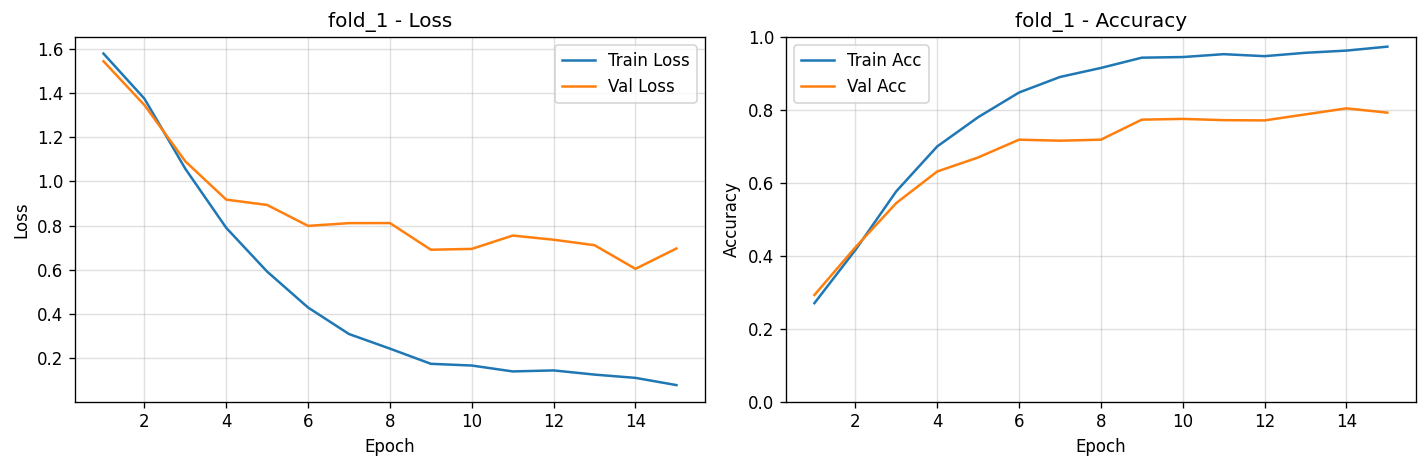

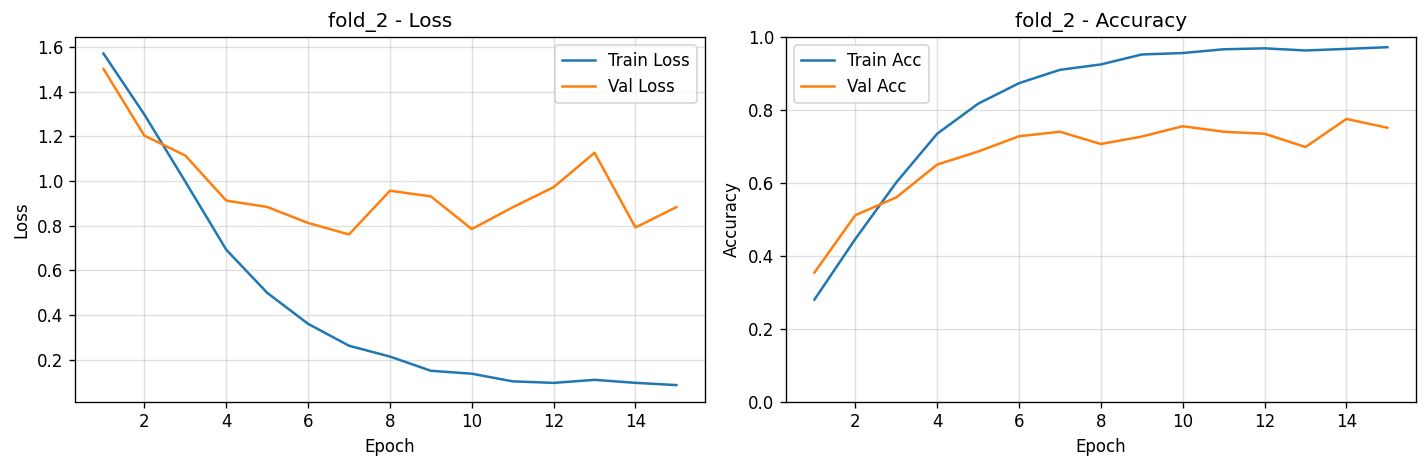

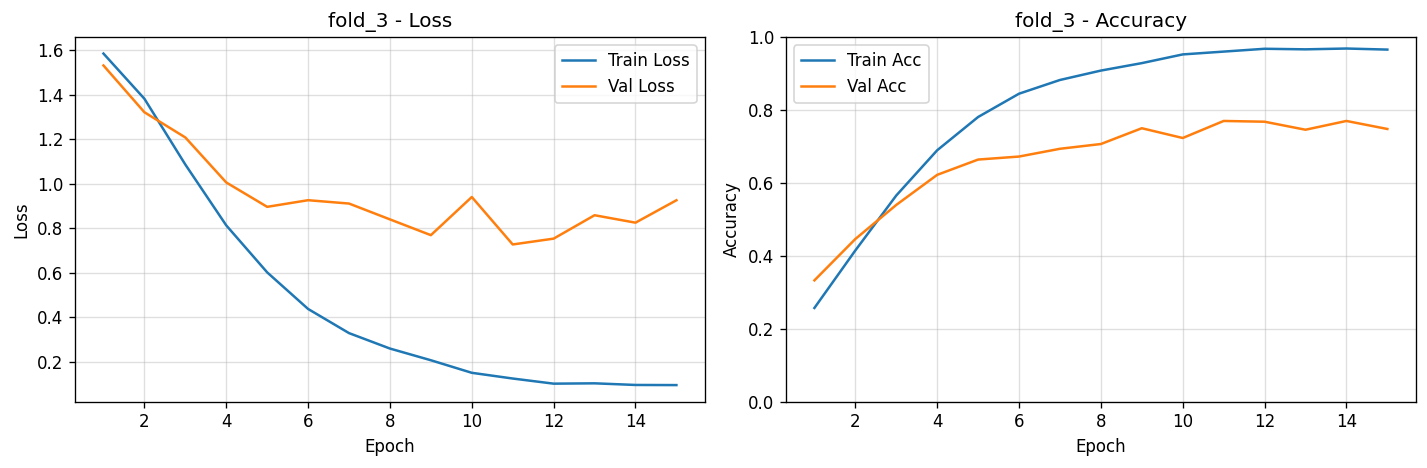

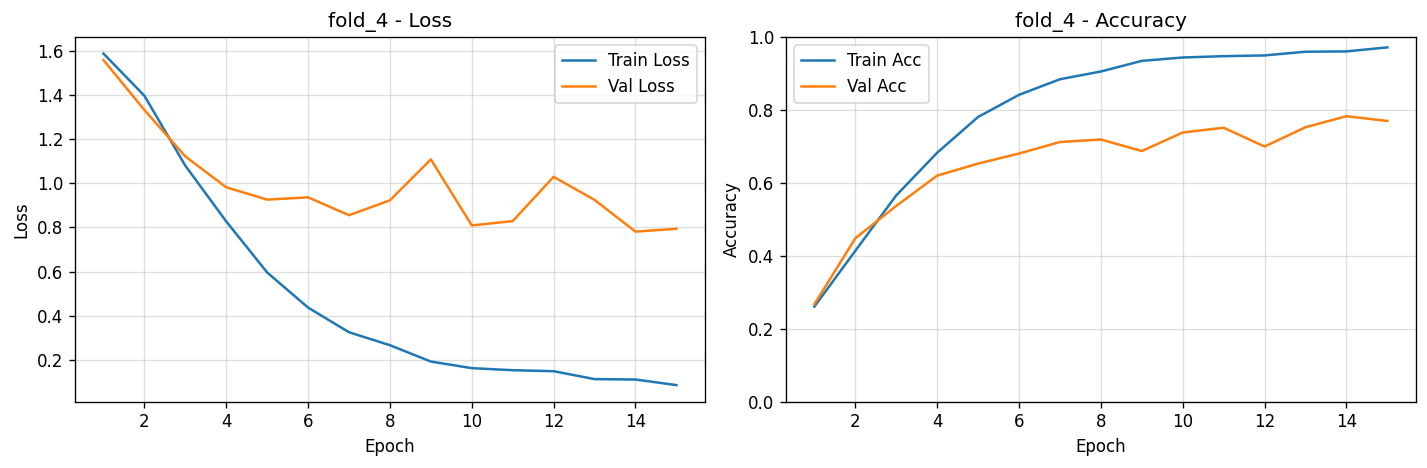

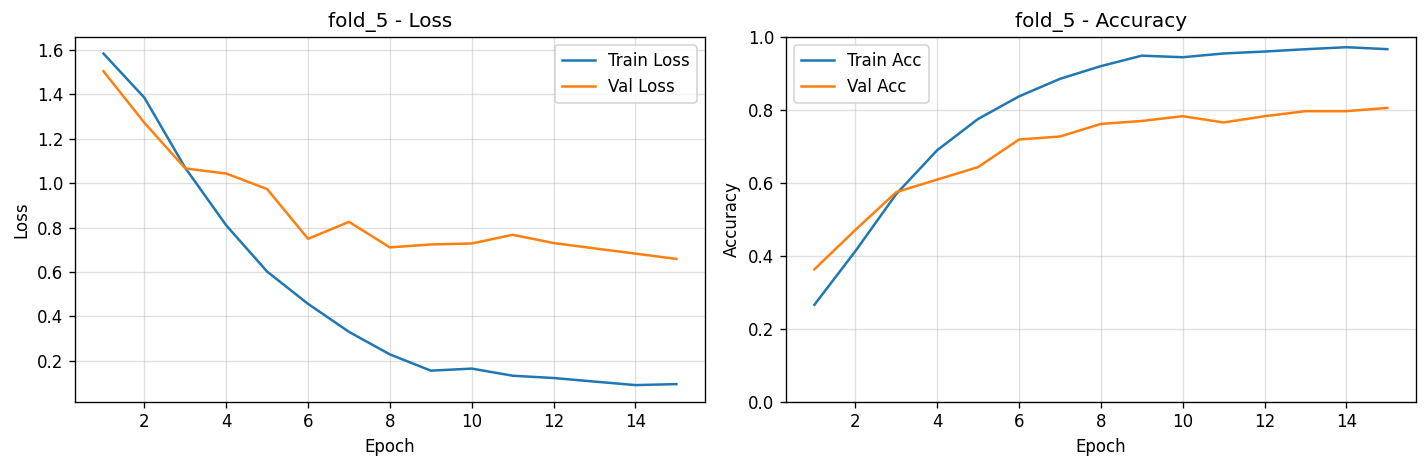

In [7]:
import pickle
import matplotlib.pyplot as plt

# =====================
# 1. LOAD DATA PKL
# =====================

dataset_path = "/kaggle/input/resultmobnetv2/all_folds_results.pkl"

with open(dataset_path, "rb") as f:
    fold_results = pickle.load(f)

print("Fold yang tersedia:", list(fold_results.keys()))

# =====================
# 2. FUNGSI SORT FOLD
# =====================

def _fold_sort_key(name):
    # Ambil angka dari nama fold, misal "fold_3" -> 3
    parts = name.replace('-', '_').split('_')
    for p in parts:
        if p.isdigit():
            return int(p)
    return 0

# Urutkan fold berdasarkan angkanya
fold_names_sorted = sorted(fold_results.keys(), key=_fold_sort_key)

# =====================
# 3. VISUALISASI
# =====================

for fold_name in fold_names_sorted:
    fr = fold_results[fold_name]

    train_losses = fr.get("train_losses", [])
    val_losses   = fr.get("val_losses", [])
    train_accs   = fr.get("train_accs", [])
    val_accs     = fr.get("val_accs", [])

    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)

    # -------- LOSS --------
    axes[0].plot(epochs, train_losses, label="Train Loss")
    axes[0].plot(epochs, val_losses, label="Val Loss")
    axes[0].set_title(f"{fold_name} - Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.4)
    axes[0].legend()

    # -------- ACC --------
    axes[1].plot(epochs, train_accs, label="Train Acc")
    axes[1].plot(epochs, val_accs, label="Val Acc")
    axes[1].set_title(f"{fold_name} - Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.4)
    axes[1].legend()

    plt.tight_layout()
    plt.show()